 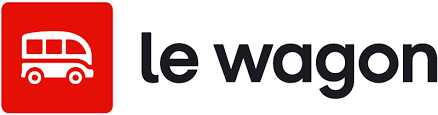

# Predict Greenweez Churners


In this challenge were are going to look at the Greenweez client database!

We want to find out who amongst our existing database of clients will reconvert 🔁 (ie. make a second purchase) within 3 months.

**Our data**

➡️ We have access to the sales from 2019 to 2021.

➡️ Let's take a look


## Data exploration


a) Execute the cell below to load our client data into a dataframe variable called `df`.

In [1]:
from google.colab import auth
import pandas as pd

# Will collect your credentials
auth.authenticate_user()

# Query Bigquery
query = "SELECT * FROM `data-analytics-bootcamp-363212.course33.gwz_churn`"
project = "data-analytics-bootcamp-363212"

df = pd.read_gbq(query=query, project_id=project)

b) Let's take a look at our data.

1. As usual, it's useful to first look at the first few rows.
2. What's the shape of our data?
3. Are there any null values?  
4. Given that we are trying to predict 'reconversions', what is our target?

In [2]:
df.head()

,date_date,orders_id,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
0,2021-03-08,797405,207754,3,65.456667,196.37,29.333333,88,0,23.000000,1,0
1,2021-06-23,914331,229390,2,84.650000,169.30,40.000000,80,0,34.500000,1,0
2,2021-04-27,857750,4921,3,48.343333,145.03,20.000000,60,0,11.666667,1,1
3,2021-02-28,786589,10797,8,74.970000,599.76,26.500000,212,0,20.750000,8,1
4,2021-06-08,901782,116681,3,62.113333,186.34,16.666667,50,0,9.333333,1,0


In [3]:
df.shape

(381398, 12)

In [4]:
df.isnull().sum()

date_date                   0
orders_id                   0
customers_id                0
nb_past_orders              0
avg_basket                  0
total_purchase_cost         0
avg_quantity                0
total_quantity              0
nb_days_since_last_order    0
avg_nb_unique_products      0
total_nb_codes              0
re_purchase                 0
dtype: int64

<details>
    <summary><i>Answer:</i></summary>
     
Your DataFrame should be of shape 381398 * 12.
    
The target is the `re_purchase` column, and the other columns will be your features.
    
There are no null values in data.
</details>        

c) What do you think of column `orders_id` for our problem? Is it useful for our analysis?

<details>
    <summary><i>Answer:</i></summary>

Orders_id is not useful in this case! It is the unique identifier for the Greenweez database, but doesn't provide any info that we use to predict reconversions.
</details>   

d) Now, delete `orders_id` and `date_date` columns.

In [5]:
df = df.drop(columns=['date_date', 'orders_id'])

e) Have a look at whether our columns values are on different scales. To do this, use the DataFrame `.describe()` method to compare them.

What kind of preprocessing we will have to use ?

In [6]:
df.describe()

,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
count,381398.0,381398.0,381398.000000,381398.000000,381398.000000,381398.0,381398.0,381398.000000,381398.0,381398.0
mean,161066.560242,2.058692,51.570302,124.525402,13.558555,33.825301,0.0,8.392141,0.544751,0.476864
std,95853.282456,2.030991,41.144718,291.427518,13.202761,71.181359,0.0,7.364444,1.441715,0.499465
min,2.0,1.0,0.000000,0.000000,1.000000,1.0,0.0,1.000000,0.0,0.0
25%,69762.0,1.0,26.290000,30.310000,5.500000,7.0,0.0,3.000000,0.0,0.0
50%,174880.0,1.0,43.760000,65.550000,10.333333,16.0,0.0,6.500000,0.0,0.0
75%,244394.0,2.0,66.840000,150.350000,18.000000,38.0,0.0,11.500000,1.0,1.0
max,314334.0,61.0,4726.440000,22738.110000,1480.000000,3557.0,0.0,163.000000,57.0,1.0


<details>
    <summary><i>Answer:</i></summary>

The features are indeed on different scales. For example, total_nb_codes in comparison with avg_basket.

As a result, we will need to use a normalization technique.
</details>

f) Set column `customers_id` as index to keep customer_id information.

In [7]:
df = df.set_index('customers_id')

Note that for the sake of the exercise, we've **already preprocessed some of the data for you** 🔧.

This means you'll be working on a (relatively) clean database, with your targets and features already formed. In a real-world situation, it's likely that you'll be spending a lot of time forming your target and features from simpler, less-specific data, either using python or SQL to manipulate the database.

## Modeling

Now that we've seen what our data looks like, we need to define our target and features.

a) Split dataset into a train and a test set (this should give you an `X_train`, `X_test`, `y_train` and `y_test`).

We will keep a test_size of 20%.

In [8]:
from sklearn.model_selection import train_test_split

# every columns except re_purchase which is our target
X = df.drop(columns='re_purchase')
y = df['re_purchase']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# store customers_ids for after
test_customers_ids = X_test.index

b) Execute the cell below to apply normalization on our data. We are going to use a StandardScaler for this transformation.

*Make sure you understand what this code does.*

Why do we use `.fit_transform()` on the train set and `.transform()` on the test set?

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# apply same transformation on X_test
X_test = scaler.transform(X_test)

c) What are the types of X_train and X_test?

In [10]:
display(type(X_train), type(X_test))

numpy.ndarray

numpy.ndarray

d) Before building our first model we need a baseline to compare our futur models!

For this example, calculate the score for a stupid model returning always 1.

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

baseline_y_pred = pd.Series(np.ones([76280]))

baseline_accuracy = accuracy_score(y_test, baseline_y_pred)

print(f"Baseline accuracy is {round(baseline_accuracy,2)}")

Baseline accuracy is 0.48


Now that we have a baseline, even if it's poor, we will try to surpass it!

e) Let's build our first model now!

We will use a simple logistic regression model. Execute cell below to train your model on the train data and store the test data predictions in a variable `y_pred`.

Make sure you understand what this code does.

In [12]:
from sklearn.linear_model import LogisticRegression

# train model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# store predictions
y_pred = clf.predict(X_test)

f) Calculate the accuracy you get on test data.

How do you interpret this value?

In [13]:
accuracy_test = clf.score(X_test, y_test)

print(f"test data accuracy = {round(accuracy_test, 3)}")


test data accuracy = 0.73


<details>
    <summary><i>Answer:</i></summary>

Logistic regression score corresponds to accuracy.
We see here 73% accuracy on both train and test data. It means that 73% of our predictions are good.

There is no overfitting as there is no difference in scores between train and test
</details>

g) Accuracy is one way to judge model performance, but plotting a confusion matrix on the test data can be more informative. This is because you can calculate additional metrics from this matrix!

Execute cell below to plot confusion matrix.

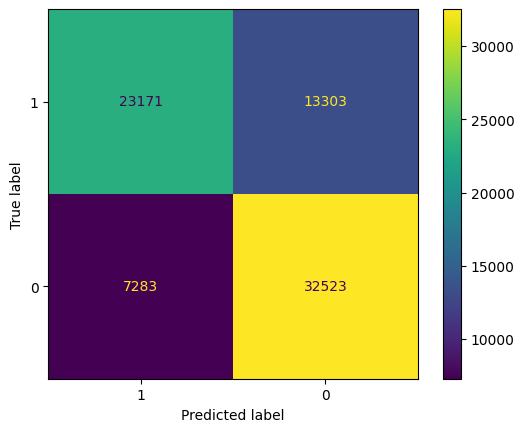

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,labels=[1, 0])

h) From your confusion matrix and the below picture, calculate:
- precision
- recall
- accuracy

Remember to make sure you are using the values associated with the correct labels when doing so!

![confusionmetrucs](https://yury-zablotski.netlify.app/post/confusion-matrix/ssw.png)

<details>
    <summary><i>Answer:</i></summary>

- precision: 23142 / (23142 + 7269) = 23142 / 30411 = 75.94%
- recall: 23142 / (13150 + 23142) = 23142 / 36292 = 63.77%
- accuracy: (32719 + 23142) / 76280 = 55861 / 76280 = 73.23%
</details>

i) What is the percent of churners your model correctly detected? Is it good?

<details>
    <summary><i>Answer:</i></summary>

number_churners_correctly_detected / number_of_churners = 32719 / (32719 + 7269) = 32504 / 39988 = 81.82%

Not bad at all, we have now a model to identify 81.82% of churners :)
</details>

j) What does the code below do? Why would this be useful from a business perspective?

In [15]:
proba = pd.DataFrame(clf.predict_proba(X_test), columns=["Churner", "Not churner"], index=test_customers_ids)
proba

,Churner,Not churner
customers_id,,
223390,0.725338,0.274662
266778,0.036857,0.963143
224012,0.729824,0.270176
222466,0.792827,0.207173
230806,0.495567,0.504433
...,...,...
105047,0.797865,0.202135
195814,0.669923,0.330077
125594,0.117578,0.882422


<details>
    <summary><i>Answer:</i></summary>

We can get probability to repurchase or not (column not churner).
</details>

k) Filter this dataframe on customers who have between 20% and 50% probability to re purchase.

Customers with a probability of less than 20% to repurchase are considered lost.

In [16]:
proba[(proba["Not churner"] >= 0.2) & (proba["Not churner"] < 0.5)]

,Churner,Not churner
customers_id,,
223390,0.725338,0.274662
224012,0.729824,0.270176
222466,0.792827,0.207173
149397,0.746589,0.253411
202905,0.760474,0.239526
...,...,...
285139,0.728431,0.271569
247350,0.736316,0.263684
105047,0.797865,0.202135


l) Well done! You now have a model that predicts churners.

Using this model, suggest a process that can be implemented at GreenWeez to help the company reduce the churn rate.


<details>
    <summary><i>Answer:</i></summary>

On a regular basis, predict possible churners and send this info back to the CRM via ELT.

The CRM team will then target those users who are predicted as likely to churn by sending them coupon codes, discounts, ...
things that will hopefully retain them!
</details>